In [157]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np 
import re

In [16]:
df = pd.read_csv("C:/Users/Admin/Desktop/drom_webscraping.csv")
data = df.copy()
data.head()

,Link,Title,Subtitle,Description,Price,Location
0,https://auto.drom.ru/moscow/mercedes-benz/c-cl...,"Mercedes-Benz C-Class, 1997",NaN,"2.0 л (136 л.с.),бензин,механика,задний,345 80...",200 000,Москва
1,https://auto.drom.ru/novosibirsk/mercedes-benz...,"Mercedes-Benz C-Class, 1995",C200 АT Elegance,"2.0 л (136 л.с.),бензин,АКПП,задний,290 000 км",198 000,Новосибирск
2,https://auto.drom.ru/novosibirsk/mercedes-benz...,"Mercedes-Benz A-Class, 2002",A 160,"1.6 л (102 л.с.),бензин,АКПП,передний,397 000 км",185 000,Новосибирск
3,https://auto.drom.ru/novosibirsk/mercedes-benz...,"Mercedes-Benz E-Class, 1989",200 E MT5 Base,"2.0 л (122 л.с.),бензин,механика,задний,152 00...",150 000,Новосибирск
4,https://auto.drom.ru/vladivostok/mercedes-benz...,"Mercedes-Benz Mercedes, 1992",NaN,"2.5 л (90 л.с.),механика,задний,50 000 км",110 000,Владивосток


In [17]:
data.shape

(14128, 6)

In [18]:
data = data.rename(columns={"Title":"Car Title"})
data[['Car', 'Year']] = data['Car Title'].str.split(', ', expand=True)
data["Year"] = pd.to_numeric(data['Year'], errors='coerce')

In [ ]:
def parse_specs(spec):
    engine = fuel = transmission = drive = mileage = color = np.nan
    
    # split into comma-separated parts
    parts = [p.strip().lower() for p in spec.split(",")]
    
    # dictionaries/lists
    fuels = ["бензин", "дизель", "электро", "гибрид", "газ"]
    transmissions = ["механика", "акпп", "робот", "вариатор", "автомат"]
    drives = ["передний", "задний", "полный", "4wd"]
    colors = ['синий', 'серый', 'серебристый', 'белый', 'черный', 'зеленый',
              'красный', 'коричневый']
    
    # ---- ENGINE VOLUME ----
    vol = re.search(r"([\d\.]+)\s*л", spec.lower())
    if vol:
        engine = vol.group(1) + " л"

    # ---- HORSEPOWER ----
    hp = re.search(r"\((\d+)\s*л\.с\.\)", spec.lower())
    if hp:
        if engine is np.nan:
            engine = ""
        engine = f"{engine} ({hp.group(1)} л.с.)"

    # ---- FUEL (keyword search; not dependent on order) ----
    for f in fuels:
        if f in spec.lower():
            fuel = f
            break

    # ---- TRANSMISSION ----
    for p in parts:
        for t in transmissions:
            if t == p:
                transmission = t
                break

    # ---- DRIVE ----
    for p in parts:
        for d in drives:
            if d == p:
                drive = d
                break

    # ---- COLOR ----
    for c in colors:
        if c in spec.lower():
            color = c
            break

    # ---- MILEAGE ----
    m = re.search(r"([\d\s]+)\s*км", spec.lower())
    if m:
        mileage = m.group(1).strip().replace(" ", "") + " км"
    
    return pd.Series([engine, fuel, transmission, drive, color, mileage])

data[['Engine', 'Fuel', 'Transmission','Drive','Color','Mileage']] = (
    data['Description'].apply(parse_specs)
)

In [86]:
def extract_engine_values(engine):
    if pd.isna(engine):
        return pd.Series([np.nan, np.nan])

    # Extract engine volume (e.g., 2.0)
    vol_match = re.search(r"(\d\.\d)\s*л", engine)

    # Extract horsepower (e.g., 150)
    hp_match = re.search(r"(\d+)\s*л\.с", engine)

    vol = float(vol_match.group(1)) if vol_match else np.nan
    hp = int(hp_match.group(1)) if hp_match else np.nan

    return pd.Series([vol, hp])

data[["EngineVolume", "Horsepower"]] = data["Engine"].apply(extract_engine_values)

In [87]:
data.columns

Index(['Car', 'Year', 'Price', 'Location', 'Color', 'Engine', 'Fuel',
       'Transmission', 'Drive', 'Mileage', 'Subtitle', 'Car Title',
       'Description', 'Link', 'EngineVolume', 'Horsepower'],
      dtype='object')

In [89]:
new_order = ["Car", "Year","Price","Location","EngineVolume",'Horsepower','Fuel','Transmission', 'Drive', 'Mileage',"Color",'Engine','Subtitle','Car Title', 'Description',"Link"]
data["Color"] = data["Color"].fillna("Unknown")
data = data[new_order]
data.head()

,Car,Year,Price,Location,EngineVolume,Horsepower,Fuel,Transmission,Drive,Mileage,Color,Engine,Subtitle,Car Title,Description,Link
0,Mercedes-Benz C-Class,1997,200000,Москва,2.0,136.0,Бензин,Механика,Задний,345800 км,Unknown,2.0 л (136 л.с.),Unknown,"Mercedes-Benz C-Class, 1997","2.0 л (136 л.с.),бензин,механика,задний,345 80...",https://auto.drom.ru/moscow/mercedes-benz/c-cl...
1,Mercedes-Benz C-Class,1995,198000,Новосибирск,2.0,136.0,Бензин,Акпп,Задний,290000 км,Unknown,2.0 л (136 л.с.),C200 АT Elegance,"Mercedes-Benz C-Class, 1995","2.0 л (136 л.с.),бензин,АКПП,задний,290 000 км",https://auto.drom.ru/novosibirsk/mercedes-benz...
2,Mercedes-Benz A-Class,2002,185000,Новосибирск,1.6,102.0,Бензин,Акпп,Передний,397000 км,Unknown,1.6 л (102 л.с.),A 160,"Mercedes-Benz A-Class, 2002","1.6 л (102 л.с.),бензин,АКПП,передний,397 000 км",https://auto.drom.ru/novosibirsk/mercedes-benz...
3,Mercedes-Benz E-Class,1989,150000,Новосибирск,2.0,122.0,Бензин,Механика,Задний,152000 км,Unknown,2.0 л (122 л.с.),200 E MT5 Base,"Mercedes-Benz E-Class, 1989","2.0 л (122 л.с.),бензин,механика,задний,152 00...",https://auto.drom.ru/novosibirsk/mercedes-benz...
4,Mercedes-Benz Mercedes,1992,110000,Владивосток,2.5,90.0,NaN,Механика,Задний,50000 км,Unknown,2.5 л (90 л.с.),Unknown,"Mercedes-Benz Mercedes, 1992","2.5 л (90 л.с.),механика,задний,50 000 км",https://auto.drom.ru/vladivostok/mercedes-benz...


In [ ]:
data.replace("N/A", np.nan, inplace=True)
data[["Location","Color","Fuel","Transmission","Drive"]] = data[["Location","Color","Fuel","Transmission","Drive"]].apply(lambda x: x.str.title())

Car                 0
Year                0
Price               0
Location            0
Color           14054
Engine             29
Fuel               45
Transmission       28
Drive              31
Mileage           257
Subtitle         3818
Car Title           0
Description         0
Link                0
dtype: int64

In [ ]:
data.drop_duplicates(inplace=True)
data["Price"] = data["Price"].str.replace("\xa0","").str.replace("₽","").str.replace(" ","")
data["Price"] = pd.to_numeric(data["Price"], errors='coerce')
data["Mileage_num"] = data["Mileage"].str.replace(" км","").str.replace(" ","")
data["Mileage_num"] = pd.to_numeric(data["Mileage_num"], errors='coerce')

In [73]:
data["Location"] = data["Location"].str.replace("→", ", ")

In [91]:
data.dtypes

Car              object
Year              int64
Price             int64
Location         object
EngineVolume    float64
Horsepower      float64
Fuel             object
Transmission     object
Drive            object
Mileage          object
Color            object
Engine           object
Subtitle         object
Car Title        object
Description      object
Link             object
dtype: object

In [98]:
data.isna().sum()

Car                 0
Year                0
Price               0
Location            0
EngineVolume       35
Horsepower         48
Fuel               42
Transmission       26
Drive              29
Mileage           225
Color           12317
Engine             27
Subtitle         3336
Car Title           0
Description         0
Link                0
dtype: int64

In [148]:
"""
EDA, Exploratory Data Analysis
"""


'\nEDA, Exploratory Data Analysis\n'

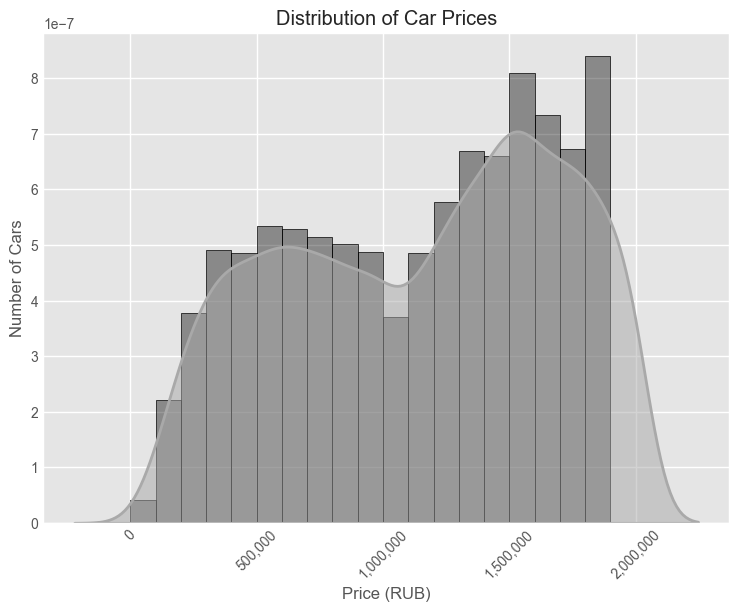

In [187]:
#the price distribution of all cars

plt.style.use('ggplot')
plt.figure(figsize=(7,5))
bins = np.arange(0, 2000000, 100000)
bins = np.arange(0, 2000000, 100000)
sns.histplot(
    data=data, x="Price", bins=bins,color="k",edgecolor='black', alpha=0.4,stat="density"
)

sns.kdeplot(
    data=data, x="Price",color="darkgrey",fill=True, alpha=0.5, linewidth=2
)
plt.xticks(rotation=45)
plt.gca().get_xaxis().set_major_formatter(
    mticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xlabel("Price (RUB)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Car Prices")
plt.show()

In [110]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']